#### 1) Zero-Coupon Yields (Bootstrapping)


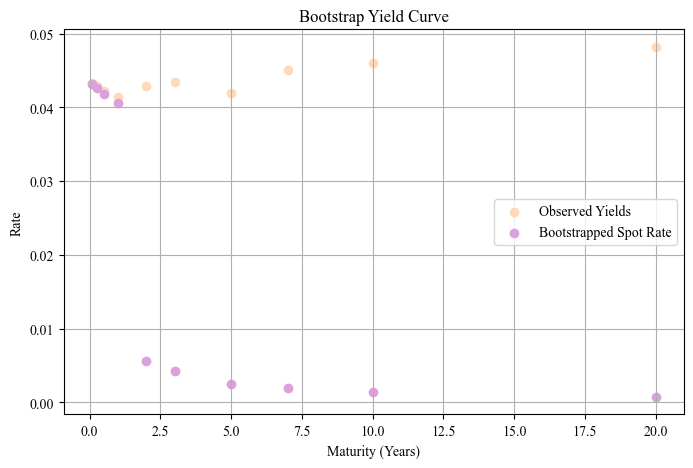

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve, log

# Data
data = { 'Year': [1/12, 3/12, 6/12, 1, 2, 3, 5, 7 ,10, 20],
         'Yield': [0.0433, 0.0429, 0.0422, 0.0414, 0.0429, 0.0434, 0.042, 0.0451, 0.046, 0.0482]}
df = pd.DataFrame(data)

spot = []

# Get spot rates for T ≤ 1 year
for i in range(0, 4):
    T = df['Year'][i]
    P = 1 - df['Yield'][i] * T
    if P <= 0:
        raise ValueError(f"Invalid discount factor P={P} at T={T}")  # Debugging check
    zcy = -1/T * np.log(P)
    spot.append(zcy)

# Get spot rates for T > 1 year
x = symbols('x')
for i in range(4, 10):
    T = df['Year'][i]
    mkt_rate = df['Yield'][i]
    
    # Compute sum of previous spot rates correctly
    prev_spots_sum = sum(spot[2:i-1]) if i > 4 else 0  
    
    # Bootstrap equation
    eq = Eq(0.5 * mkt_rate * (prev_spots_sum + (spot[i-1] + x)/2 + x) + x - 1, 0)
    solution = solve(eq, x)[0]
    
    # Convert to numeric and apply log correctly
    solution = float(solution)
    if solution <= 0:
        raise ValueError(f"Invalid solution={solution} at T={T}")  # Debugging check
    spot_rate = -1/T * log(solution)
    spot.append(float(spot_rate))  # Ensure it's a numeric value

df['Spot'] = spot  # Update DataFrame

# Plot 
plt.figure(figsize=(8,5))
plt.rcParams['font.family'] = 'times new roman'
plt.scatter(df['Year'], df['Yield'], marker='o', label='Observed Yields', color='peachpuff')  # Fixed marker
plt.scatter(df['Year'], df['Spot'], marker='o', label='Bootstrapped Rate', color='plum')  # Fixed line plot
plt.xlabel('Maturity (Years)')
plt.ylabel('Rate')
plt.title('Bootstrap Yield Curve')
plt.legend()
plt.grid(True)
plt.show()


#### 2) Zero-Coupon Yields (Nelson-Siegel-Svensson) 

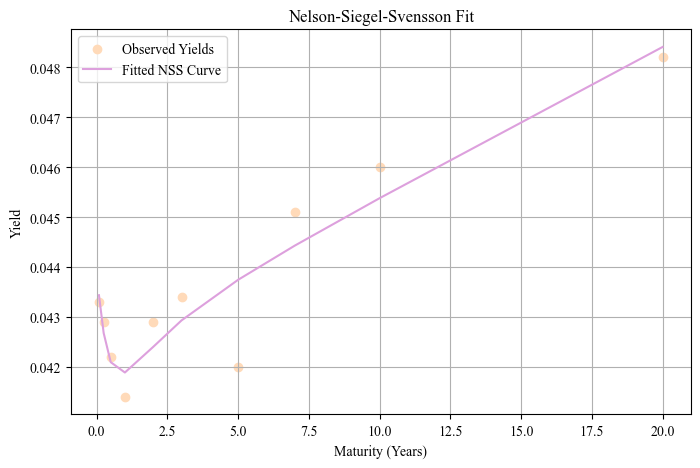

Objective Function (SSE) = 0.0000047095
                  0         1         2         3         4           5
Parameter        β0        β1        β2        β3        τ1          τ2
Value      0.042665  0.001319 -0.005431 -0.543325  0.440554 -944.765301


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Nelson-Siegel-Svensson model
def nss_model(t, beta_0, beta_1, beta_2, beta_3, tau_1, tau_2):
    t = np.maximum(t, 1e-6)  # Avoid division by zero
    term1 = (1 - np.exp(-t/tau_1)) / (t/tau_1)
    term2 = term1 - np.exp(-t/tau_1)
    term3 = (1 - np.exp(-t/tau_2)) / (t/tau_2) - np.exp(-t/tau_2)
    return beta_0 + beta_1 * term1 + beta_2 * term2 + beta_3 * term3

# Initial guess
initial_guess = [0.04, -0.02, 0.02, -0.01, 1.0, 5.0]

# Fit model to data (convert pandas Series to NumPy arrays)
params, covariance = curve_fit(nss_model, df['Year'].values, df['Yield'].values, p0=initial_guess)

# Extract fitted parameters
beta_0, beta_1, beta_2, beta_3, tau_1, tau_2 = params

# Compute fitted yields using estimated parameters
fitted_yields = nss_model(df['Year'].values, *params)

# Objective function (sum of squared errors)
sse = np.sum((df['Yield'].values - fitted_yields) ** 2)

# Plot 
plt.figure(figsize=(8,5))
plt.rcParams['font.family'] = 'times new roman'

# Scatter plot for observed yields
plt.scatter(df['Year'], df['Yield'], marker='o', label='Observed Yields', color='peachpuff')

# Line plot for the fitted NSS curve
plt.plot(df['Year'], fitted_yields, '-', label='Fitted NSS Curve', color='plum')

plt.xlabel('Maturity (Years)')
plt.ylabel('Yield')
plt.title('Nelson-Siegel-Svensson Fit')
plt.legend()
plt.grid(True)
plt.show()

# Output results
print(f"Objective Function (SSE) = {sse:.10f}")

# Create DataFrame for fitted parameters
fitted_parameters = pd.DataFrame({'Parameter': ['β0', 'β1', 'β2', 'β3', 'τ1', 'τ2'],
                                  'Value': [beta_0, beta_1, beta_2, beta_3, tau_1, tau_2]})

# Transpose DataFrame for display
print(fitted_parameters.T)


#### 3) Cap Prices (Brigo-Mercurio)

In [13]:
from scipy.optimize import minimize
from scipy.stats import norm

# implied volatilities on cap market
data_caps = { 'Year': [1,3,5,7,10,20],
            '0.95Kf': [0.157, 0.176,0.175,0.168, 0.155, 0.142],
            'Kf':[0.152, 0.164,0.161,0.156, 0.148, 0.126],
            '1.05Kf':[0.146, 0.157, 0.158, 0.152, 0.140, 0.121]}
df_caps = pd.DataFrame(data_caps)
df_caps


In [26]:
data_caps = {
    'Year': [1, 3, 5, 7, 10, 20],
    '0.95Kf': [0.157, 0.176, 0.175, 0.168, 0.155, 0.142],
    'Kf': [0.152, 0.164, 0.161, 0.156, 0.148, 0.126],
    '1.05Kf': [0.146, 0.157, 0.158, 0.152, 0.140, 0.121]
}

df_caps = pd.DataFrame(data_caps)
df_caps
print(df_caps.dtypes)


Year        int64
0.95Kf    float64
Kf        float64
1.05Kf    float64
dtype: object


In [17]:
# set of params Θ = {K, ϕ, σ, x₀} 

# Define the Brigo-Mercurio model for caplet prices (simplified for illustration)
def caplet_price(K, T, r_t, sigma):
    """
    Function to compute caplet price using a Black-like model.
    Here, r_t is the forward rate, and sigma is the implied volatility.
    """
    d1 = (np.log(r_t / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    caplet = np.exp(-r_t * T) * (r_t * norm.cdf(d1) - K * norm.cdf(d2))
    return caplet

# Define the objective function to minimize (sum of squared errors)
def objective(params, strikes, maturities, market_caps):
    """
    Objective function to minimize. It computes the pricing error between the model and market prices.
    """
    kappa, sigma, phi, x_0 = params
    error = 0
    
    # Loop over all maturities and strikes
    for i, T in enumerate(maturities):
        for j, K in enumerate(strikes):
            # Compute the forward rate (simplified assumption for r_t, could be based on the model)
            r_t = K  # Just a placeholder, needs a proper model for forward rate from CIR process
            
            # Calculate the caplet price using the Brigo-Mercurio model
            caplet_model_price = caplet_price(K, T, r_t, sigma)
            
            # Market caplet price (from the dataframe)
            market_price = market_caps[i][j]
            
            # Pricing error squared relative to the market price
            error += ((caplet_model_price - market_price) / market_price) ** 2
    
    return error

# Calibration process
def calibrate_brigo_mercurio(df_caps):
    """
    Perform the calibration to minimize the pricing error and find the best fit parameters.
    """
    # Extract strikes and maturities
    strikes = df_caps.columns[1:]  # Strikes: '0.95Kf', 'Kf', '1.05Kf'
    maturities = df_caps['Year']  # Maturities: '1', '3', '5', '7', '10', '20'
    
    # Market caps from the implied volatilities (simplified assumption)
    # In practice, you'd compute the cap prices from the implied volatilities using a Black-Scholes model
    market_caps = df_caps.iloc[:, 1:].values  # This is just a placeholder
    
    # Initial guess for the parameters (kappa, sigma, phi, x_0)
    initial_params = [0.01, 0.2, 0.02, 0]  # This is just a starting point
    
    # Use a minimizer (e.g., Nelder-Mead) to minimize the objective function
    result = minimize(objective, initial_params, args=(strikes, maturities, market_caps), method='Nelder-Mead')
    
    # Return the optimized parameters
    return result.x

# Calibrate the model
calibrated_params = calibrate_brigo_mercurio(df_caps)
print("Optimized Parameters (kappa, sigma, phi, x_0):", calibrated_params)

TypeError: unsupported operand type(s) for /: 'str' and 'str'